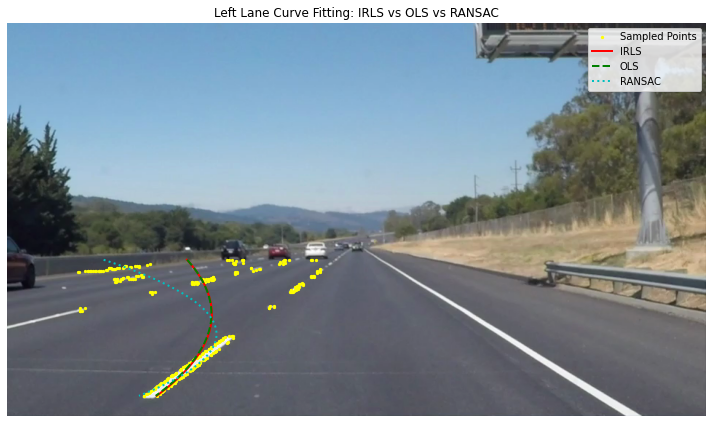

In [4]:
import sys
sys.path.append("../functions")
from irls import irls_fit

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# === Load Video and Extract First Frame ===
video_path = "../data/solidWhiteRight.mp4"
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()
if not ret:
    raise ValueError("Could not read frame from video.")

# === Edge Detection ===
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)
y_coords, x_coords = np.where(edges > 0)

# === Sample Left Lane Points ===
h, w = frame.shape[:2]
mask_l = (
    (y_coords > h * 0.6) &
    (y_coords < h * 0.95) &
    (x_coords > w * 0.1) &
    (x_coords < w * 0.45)
)
x_l = x_coords[mask_l]
y_l = y_coords[mask_l]
idx_l = np.random.choice(len(x_l), min(300, len(x_l)), replace=False)
x_sample = x_l[idx_l]
y_sample = y_l[idx_l]

# === Fit Using IRLS, OLS, RANSAC ===
y_fit = np.linspace(min(y_sample), max(y_sample), 200)
X_poly = np.vstack([y_fit**i for i in range(2, -1, -1)]).T

# IRLS
beta_irls = irls_fit(y_sample, x_sample)
x_irls = X_poly @ beta_irls

# OLS
beta_ols = np.polyfit(y_sample, x_sample, 2)
x_ols = np.polyval(beta_ols, y_fit)

# RANSAC
ransac = make_pipeline(PolynomialFeatures(2), RANSACRegressor())
ransac.fit(y_sample.reshape(-1, 1), x_sample)
x_ransac = ransac.predict(y_fit.reshape(-1, 1))

# === Plotting ===
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.scatter(x_sample, y_sample, s=5, color='yellow', label='Sampled Points')
plt.plot(x_irls, y_fit, 'r-', linewidth=2, label='IRLS')
plt.plot(x_ols, y_fit, 'g--', linewidth=2, label='OLS')
plt.plot(x_ransac, y_fit, 'c:', linewidth=2, label='RANSAC')
plt.title("Left Lane Curve Fitting: IRLS vs OLS vs RANSAC")
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()


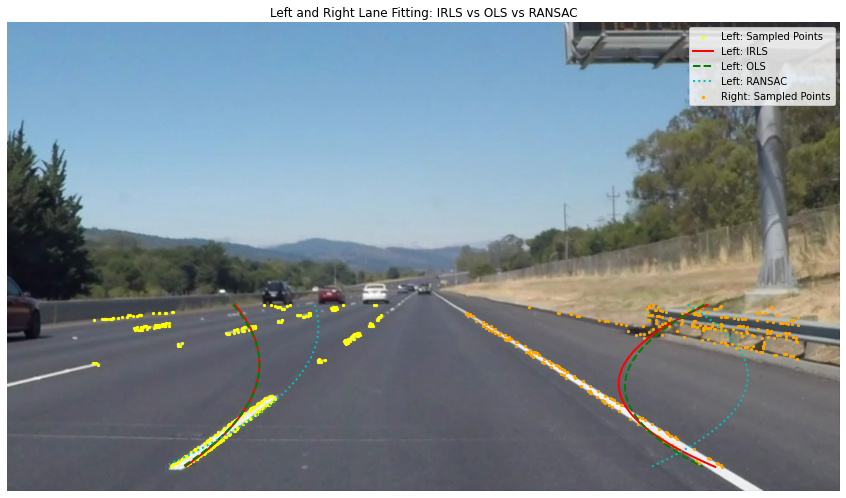

In [5]:
import sys
sys.path.append("../functions")
from irls import irls_fit

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# === Load Video and Extract One Frame ===
video_path = "../data/solidWhiteRight.mp4"
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()
if not ret:
    raise ValueError("Could not read frame from video.")

# === Edge Detection ===
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)
y_coords, x_coords = np.where(edges > 0)
h, w = frame.shape[:2]

# === Define Fitting Function ===
def fit_and_predict(x_lane, y_lane, y_fit, label):
    # IRLS
    beta_irls = irls_fit(y_lane, x_lane)
    x_irls = np.polyval(beta_irls, y_fit) if len(beta_irls) == 3 else (np.vstack([y_fit**i for i in range(2, -1, -1)]).T @ beta_irls)

    # OLS
    beta_ols = np.polyfit(y_lane, x_lane, 2)
    x_ols = np.polyval(beta_ols, y_fit)

    # RANSAC
    ransac = make_pipeline(PolynomialFeatures(2), RANSACRegressor())
    ransac.fit(y_lane.reshape(-1, 1), x_lane)
    x_ransac = ransac.predict(y_fit.reshape(-1, 1))

    return x_irls, x_ols, x_ransac

# === Process Lane (LEFT) ===
mask_l = (
    (y_coords > h * 0.6) &
    (y_coords < h * 0.95) &
    (x_coords > w * 0.1) &
    (x_coords < w * 0.45)
)
x_l = x_coords[mask_l]
y_l = y_coords[mask_l]
idx_l = np.random.choice(len(x_l), min(300, len(x_l)), replace=False)
x_sample_l = x_l[idx_l]
y_sample_l = y_l[idx_l]
y_fit_l = np.linspace(min(y_sample_l), max(y_sample_l), 200)
x_irls_l, x_ols_l, x_ransac_l = fit_and_predict(x_sample_l, y_sample_l, y_fit_l, 'Left')

# === Process Lane (RIGHT) ===
mask_r = (
    (y_coords > h * 0.6) &
    (y_coords < h * 0.95) &
    (x_coords > w * 0.55) &
    (x_coords < w * 0.95)
)
x_r = x_coords[mask_r]
y_r = y_coords[mask_r]
idx_r = np.random.choice(len(x_r), min(300, len(x_r)), replace=False)
x_sample_r = x_r[idx_r]
y_sample_r = y_r[idx_r]
y_fit_r = np.linspace(min(y_sample_r), max(y_sample_r), 200)
x_irls_r, x_ols_r, x_ransac_r = fit_and_predict(x_sample_r, y_sample_r, y_fit_r, 'Right')

# === Plot ===
plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Left lane
plt.scatter(x_sample_l, y_sample_l, s=5, color='yellow', label='Left: Sampled Points')
plt.plot(x_irls_l, y_fit_l, 'r-', linewidth=2, label='Left: IRLS')
plt.plot(x_ols_l, y_fit_l, 'g--', linewidth=2, label='Left: OLS')
plt.plot(x_ransac_l, y_fit_l, 'c:', linewidth=2, label='Left: RANSAC')

# Right lane
plt.scatter(x_sample_r, y_sample_r, s=5, color='orange', label='Right: Sampled Points')
plt.plot(x_irls_r, y_fit_r, 'r-', linewidth=2)
plt.plot(x_ols_r, y_fit_r, 'g--', linewidth=2)
plt.plot(x_ransac_r, y_fit_r, 'c:', linewidth=2)

plt.title("Left and Right Lane Fitting: IRLS vs OLS vs RANSAC")
plt.legend(loc='upper right')
plt.axis('off')
plt.tight_layout()
plt.show()


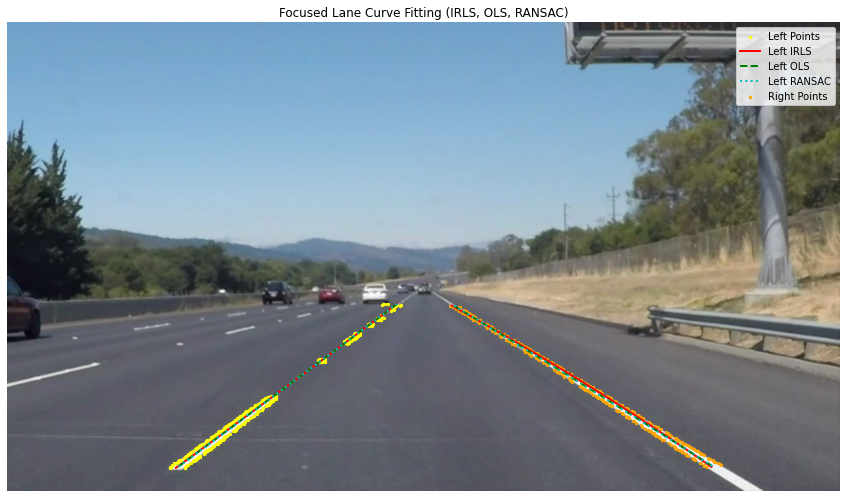

In [6]:
import sys
sys.path.append("../functions")
from irls import irls_fit

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# === Helper: Region of Interest ===
def region_of_interest(img):
    h, w = img.shape[:2]
    mask = np.zeros_like(img)
    polygon = np.array([[
        (int(w * 0.1), int(h * 0.95)),
        (int(w * 0.45), int(h * 0.6)),
        (int(w * 0.55), int(h * 0.6)),
        (int(w * 0.9), int(h * 0.95))
    ]], dtype=np.int32)
    cv2.fillPoly(mask, polygon, 255)
    masked = cv2.bitwise_and(img, mask)
    return masked

# === Fit & Predict Function ===
def fit_and_predict(x_lane, y_lane, y_fit):
    beta_irls = irls_fit(y_lane, x_lane)
    x_irls = np.polyval(beta_irls, y_fit) if len(beta_irls) == 3 else (np.vstack([y_fit**i for i in range(2, -1, -1)]).T @ beta_irls)
    beta_ols = np.polyfit(y_lane, x_lane, 2)
    x_ols = np.polyval(beta_ols, y_fit)
    ransac = make_pipeline(PolynomialFeatures(2), RANSACRegressor())
    ransac.fit(y_lane.reshape(-1, 1), x_lane)
    x_ransac = ransac.predict(y_fit.reshape(-1, 1))
    return x_irls, x_ols, x_ransac

# === Load Frame ===
video_path = "../data/solidWhiteRight.mp4"
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()
if not ret:
    raise ValueError("Failed to read frame from video.")

# === Preprocess ===
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)
edges_roi = region_of_interest(edges)

# === Sample from ROI ===
y_coords, x_coords = np.where(edges_roi > 0)
h, w = frame.shape[:2]

# LEFT lane
mask_l = (x_coords < w / 2)
x_l = x_coords[mask_l]
y_l = y_coords[mask_l]
idx_l = np.random.choice(len(x_l), min(300, len(x_l)), replace=False)
x_sample_l = x_l[idx_l]
y_sample_l = y_l[idx_l]
y_fit_l = np.linspace(min(y_sample_l), max(y_sample_l), 200)
x_irls_l, x_ols_l, x_ransac_l = fit_and_predict(x_sample_l, y_sample_l, y_fit_l)

# RIGHT lane
mask_r = (x_coords >= w / 2)
x_r = x_coords[mask_r]
y_r = y_coords[mask_r]
idx_r = np.random.choice(len(x_r), min(300, len(x_r)), replace=False)
x_sample_r = x_r[idx_r]
y_sample_r = y_r[idx_r]
y_fit_r = np.linspace(min(y_sample_r), max(y_sample_r), 200)
x_irls_r, x_ols_r, x_ransac_r = fit_and_predict(x_sample_r, y_sample_r, y_fit_r)

# === Plot ===
plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.scatter(x_sample_l, y_sample_l, s=5, color='yellow', label='Left Points')
plt.plot(x_irls_l, y_fit_l, 'r-', linewidth=2, label='Left IRLS')
plt.plot(x_ols_l, y_fit_l, 'g--', linewidth=2, label='Left OLS')
plt.plot(x_ransac_l, y_fit_l, 'c:', linewidth=2, label='Left RANSAC')

plt.scatter(x_sample_r, y_sample_r, s=5, color='orange', label='Right Points')
plt.plot(x_irls_r, y_fit_r, 'r-', linewidth=2)
plt.plot(x_ols_r, y_fit_r, 'g--', linewidth=2)
plt.plot(x_ransac_r, y_fit_r, 'c:', linewidth=2)

plt.title("Focused Lane Curve Fitting (IRLS, OLS, RANSAC)")
plt.legend(loc='upper right')
plt.axis('off')
plt.tight_layout()
plt.show()
